In [24]:
#%%
#get eigenworms using PCA 
import copy
import yaml
import numpy as np
import cv2
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import pickle
import copy
import numpy as np
import pandas as pd

import sys
import os 
import copy

from scipy.interpolate import interp1d

from functools import partial

'''change the directory below'''
import sys 
sys.path.append('/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/')

from get_data.read_neuro_beh_data_high_fps import get_exp_features as get_exp_features_fps
from beh_classification.behavior_features import get_behavior_features
from beh_classification.get_behavior_classifications import get_behavior_classification

# from beh_analysis.behavior_features import convert_angles_to_coordinates, get_beh_classification
# from get_data.read_neuro_beh_data import get_processed_beh_features
from get_data.read_neuro_beh_data import get_exp_features 
# from get_data.flavell_raw_nir_extraction.convert_nir_to_confocal import convert_nir_to_confocal
from get_data.flavell_raw_nir_extraction.convert_nir_to_confocal import convert_nir_to_confocal,convert_confocal_to_nir,  evenly_sample_nir
from beh_classification.img_mask_specific_features import get_is_looping_from_mask_dir_confocal
from beh_classification.process_midlines.midline_utils import compute_spline_lengths, get_midlines_from_worm_tracer_csv, convert_coordinates_to_angles, resample_midline, convert_angles_to_coordinates
from beh_classification.process_midlines.midline_utils import save_as_csv, load_from_csv
from beh_classification.process_midlines.eigenworm_utils import get_PCA_components_from_midlines, get_contributions_and_reconstruct_body_angles, get_cropped_midlines_eigenworms_and_body_angles

from save_img_utils.save_img_utils import get_text_nir_midlines, save_masked_imgs_and_annotations
from save_img_utils.save_resampled_imgs import save_confocal_midlines_and_masks, evenly_sample_nir_and_save, evenly_sample_feature


In [25]:
def make_new_folder(output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir

In [26]:
save_csvs = True
save_figs = True
save_imgs = True
save_mask_img = True

'''
change these directories
'''
base_save_dir = "/Users/friederikebuck/Desktop/MBL/project/outputs/"
base_code_dir = "/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/"
# base_data_dir = "/Volumes/FB1/flavell_midlines/flavell_data_processed_midlines/noheat/"
base_data_dir = "/Users/friederikebuck/Downloads/noheat/"
exp_params_yml ="/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/exp_date_params.yaml"


#2023-01-09-28"
#"2022-07-26-01"
# exp_date = "2022-07-20-01"
exp_date = "2022-06-14-01"


# exp_date ="2022-06-28-07"	
# exp_date ="2022-07-26-01"
# exp_date ="2023-01-19-15"	
# exp_date ="2023-01-23-15"
# exp_date ="2022-06-14-07"	
# exp_date ="2022-07-15-06"	
# exp_date ="2023-01-09-28"	
# exp_date ="2023-01-19-22"	
# exp_date ="2023-01-23-21"
# exp_date ="2022-06-14-13"	
# exp_date ="2022-07-15-12"	
# exp_date ="2023-01-19-01"	
# exp_date ="2023-01-23-01"	
# exp_date ="2023-03-07-01"
# exp_date ="2022-06-28-01"	
# exp_date ="2022-07-20-01"	
# exp_date ="2023-01-19-08"	
# exp_date ="2023-01-23-08"

In [27]:
'''load in high nir data sampled at higher fps 
I was using this more before we got the raw imgs; now that we have the raw images the only really relative feature here is 
nir_to_confocal = beh_data_fps["nir_to_confocal"]
which maps the frames from the nir fps to the frames in the confocal fps

need to ignore  when beh_data["nir_to_confocal"] == 0
'''

with open(exp_params_yml, 'r') as file:
    params = yaml.safe_load(file)
    if exp_date in params:
        exp_params = params[exp_date]
    else: 
        exp_params = {
            "midline_flipped": False, 
            "mask_start_end_is": []
        }

# get yaml params 
frames_to_mask = [list(range(item['start'], item['end'] + 1)) for item in exp_params['mask_start_end_is']]
if len(frames_to_mask)>0:
    frames_to_mask = np.concatenate([np.array(f) for f in frames_to_mask])
else: 
    frames_to_mask = np.array([])
is_midline_flipped = exp_params["midline_flipped"]

csv_save_dir = make_new_folder(os.path.join(base_save_dir,f"{exp_date}/csvs/"))
fig_save_dir = make_new_folder(os.path.join(base_save_dir, f"{exp_date}/figs/"))
img_save_dir = make_new_folder(os.path.join(base_save_dir, f"{exp_date}/imgs/"))

raw_nir_midlines_dir = os.path.join(base_data_dir, f"{exp_date}/results/") 
mask_img_dir = os.path.join(base_data_dir, f"{exp_date}/masked_imgs/")
bin_img_dir = os.path.join(base_data_dir, f"{exp_date}/bin_imgs/")

csv_name = os.path.join(csv_save_dir, f"nir_to_confocal.csv")
nir_to_confocal = np.loadtxt(csv_name, delimiter=",")
n_frames_nir = nir_to_confocal.shape[0]
n_frames_confocal = max(np.unique(nir_to_confocal))


target_length_fig_dir  = make_new_folder(os.path.join(fig_save_dir,"target_length_figs"))



In [28]:
'''get self-intersection frames to be incorporated in to beh classificaion (for turns )'''

is_looping_bin_img_confocal, a_to_ps, areas = get_is_looping_from_mask_dir_confocal(n_frames_nir, 
                                        n_frames_confocal
                                        ,nir_to_confocal, bin_img_dir, area_to_perimeter_ratio_thres = 1, area_to_perimeter = 6)



In [29]:
if save_csvs:
    csv_name = os.path.join(csv_save_dir, "is_looping_confocal.csv")
    print("csv_save_dir", csv_save_dir)
    np.savetxt(csv_name,  is_looping_bin_img_confocal, delimiter=",", fmt='%f')

csv_save_dir /Users/friederikebuck/Desktop/MBL/project/outputs/2022-06-14-01/csvs/


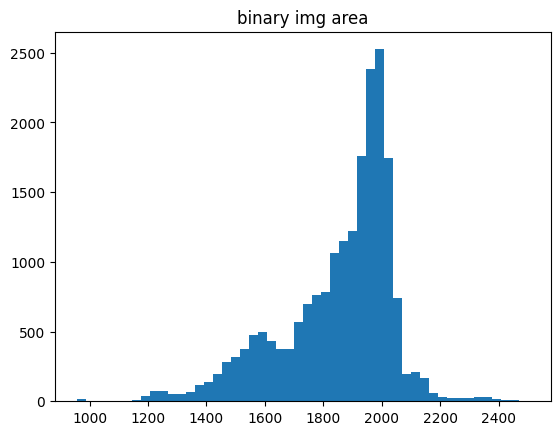

In [30]:
'''
look at areas  - probs a cut off for loopning midliens that is ok

'''

'''plot area to peirmeter ration to have good idea of good param looping frames'''
plt.hist(areas, bins = 50)
plt.title("binary img area")
plt.savefig(os.path.join(target_length_fig_dir, f"area_hist.jpeg"))
'''print example looping frames'''
looping_frames = np.argwhere(is_looping_bin_img_confocal).flatten()
n_looping = looping_frames.shape[0]
frames = np.random.randint(0, n_looping, 9).tolist()

# fig, ax = plt.subplots(3,3)
# for i, frame in enumerate(frames):
#     row, col = divmod(i, 3)
#     img = cv2.imread(os.path.join(mask_img_dir, str(looping_frames[frame]+1).zfill(5)+".png"))
#     ax[row, col].imshow(img)
    
# error = 20

# print(min(areas))
# for a_to_p_thres in np.arange(350,1500, 50):
#     looping_frames = np.argwhere(np.abs((areas-a_to_p_thres))<error).flatten()
#     n_looping = looping_frames.shape[0]
#     print("n_looping", n_looping)
#     if n_looping == 0: 
#         continue
#     n_pics = min(n_looping, 9)
#     frames = np.random.randint(0, n_looping, n_pics).tolist()
#     fig, ax = plt.subplots(3,3)
#     ax[0,0].set_title(str(a_to_p_thres))
#     for i, frame in enumerate(frames):
#         row, col = divmod(i, 3)
#         img = cv2.imread(os.path.join(mask_img_dir, str(looping_frames[frame]+1).zfill(5)+".png"))
#         ax[row, col].imshow(img)
#         ax[row,col].text(5,5,str(a_to_ps[frame]), color = "red")
#     # if save_figs:
#     #     plt.savefig(os.path.join(fig_save_dir, f"a_to_p{a_to_p_thres}_examples.jpeg"))

n_looping 934
n_looping 239
n_looping 110
n_looping 60
n_looping 34
n_looping 25
n_looping 54
n_looping 53
n_looping 50
n_looping 69
n_looping 74
n_looping 77
n_looping 38
n_looping 50
n_looping 55
n_looping 45


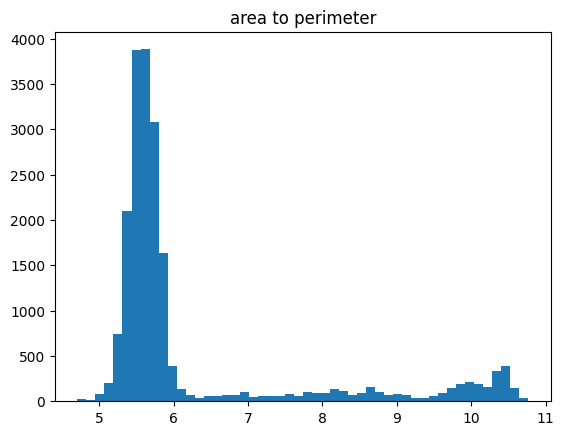

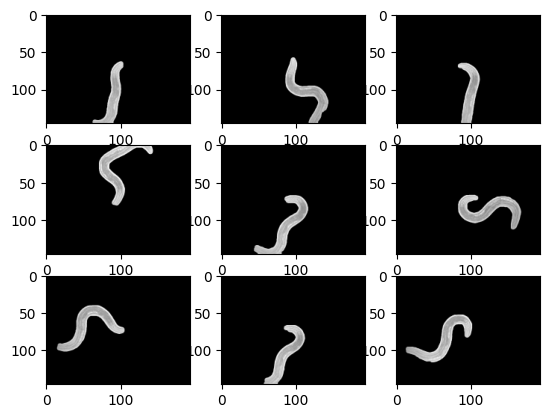

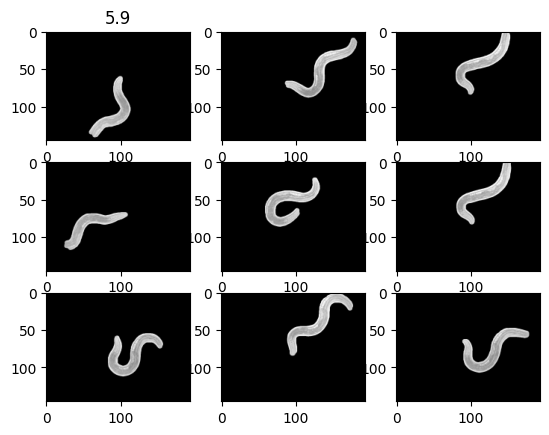

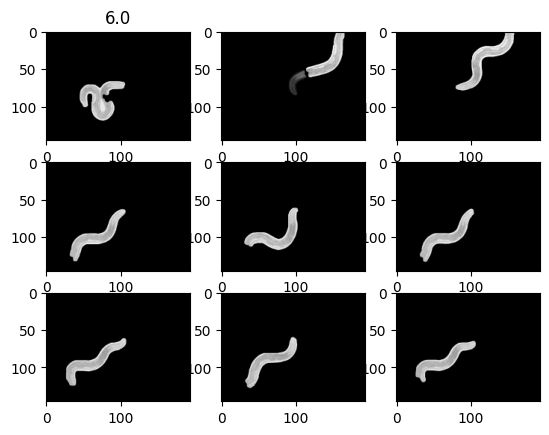

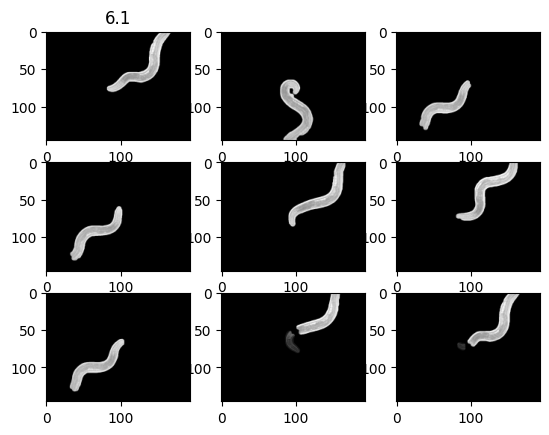

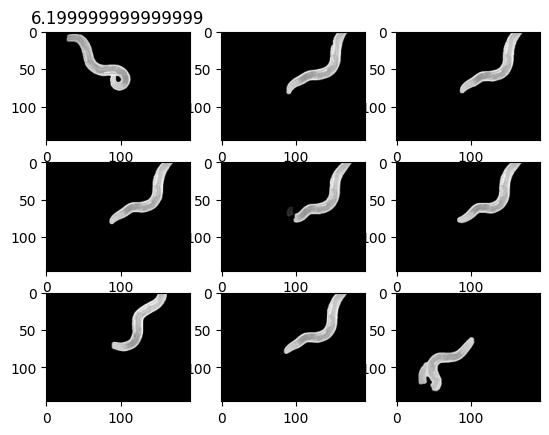

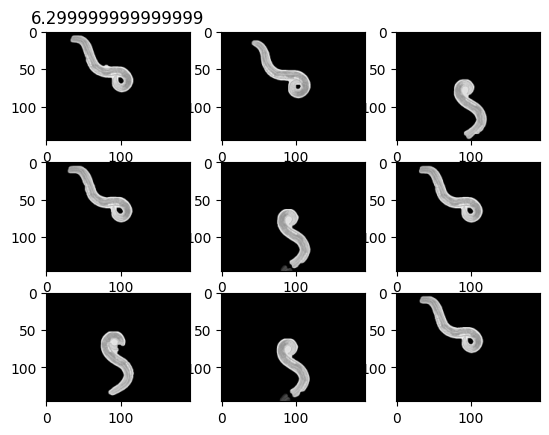

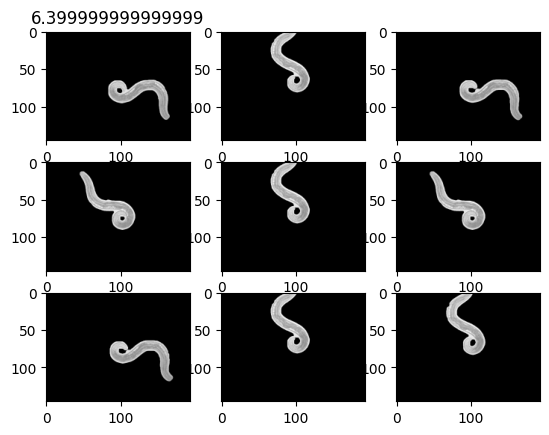

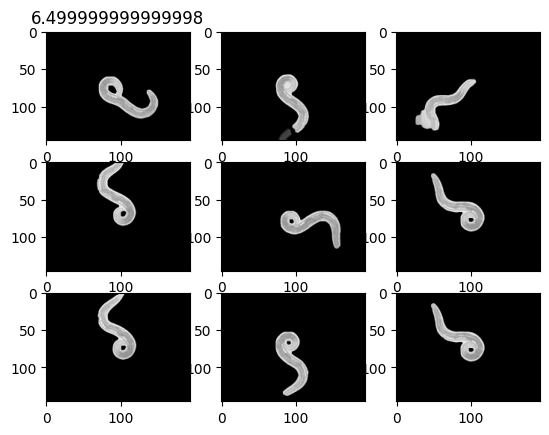

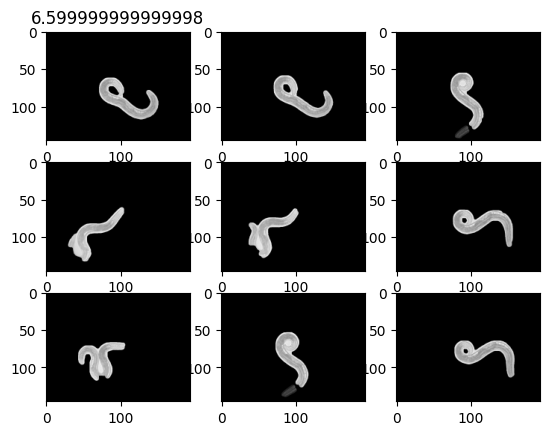

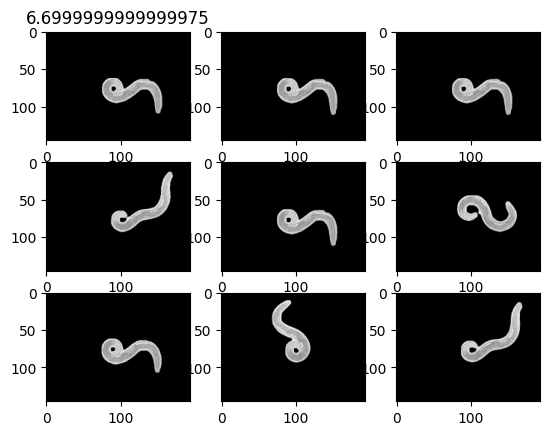

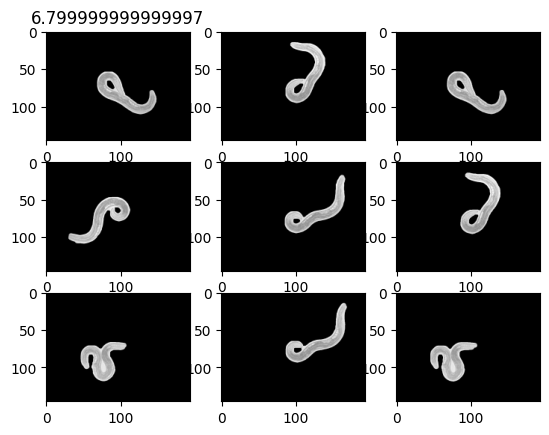

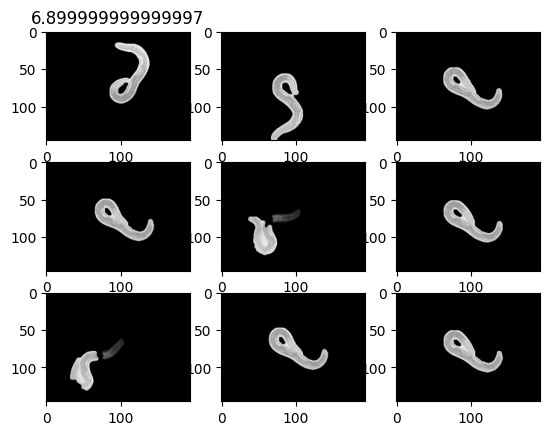

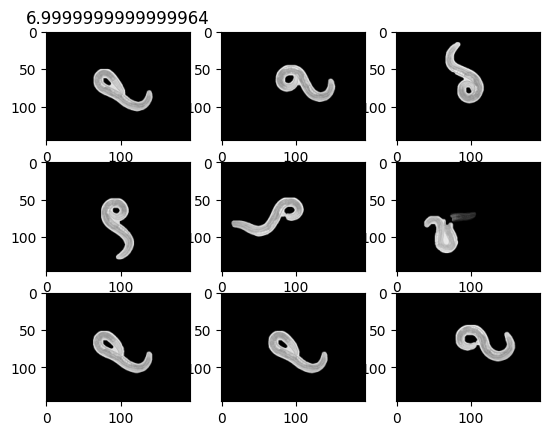

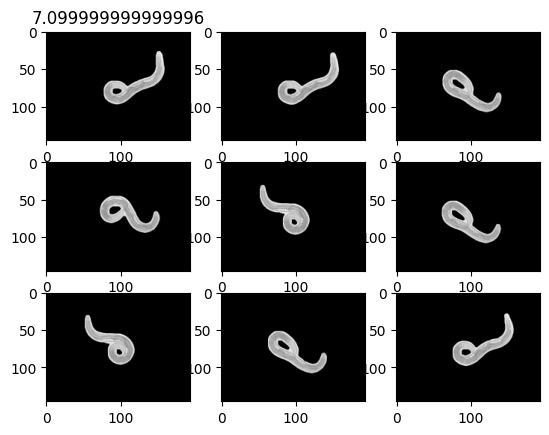

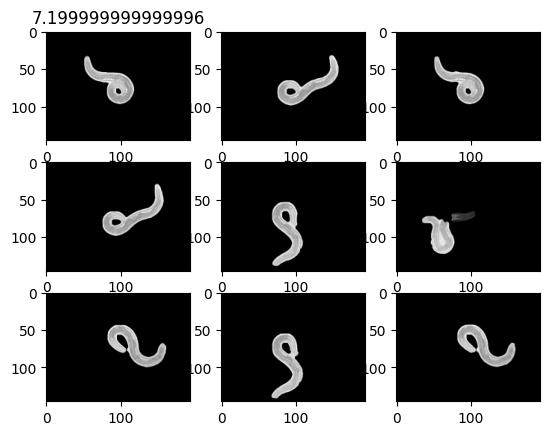

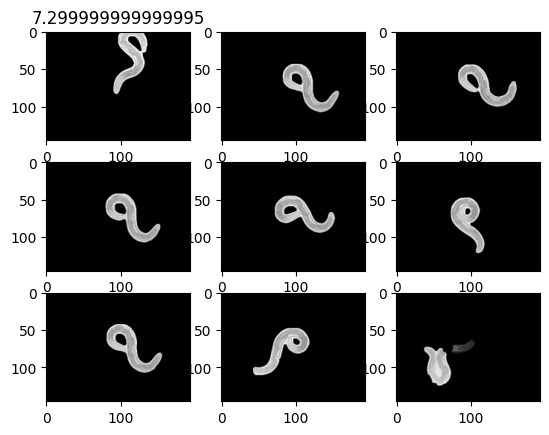

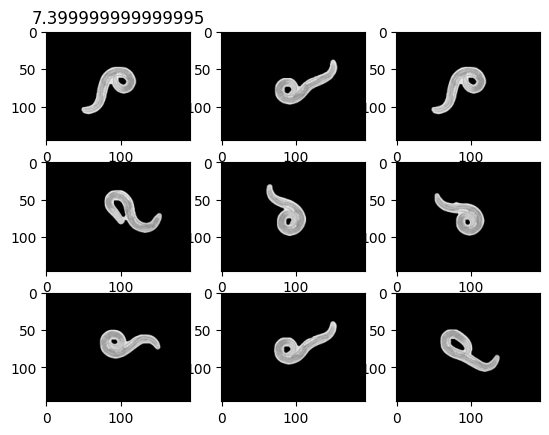

In [31]:
'''plot area to peirmeter ration to have good idea of good param looping frames'''
plt.hist(a_to_ps, bins = 50)
plt.title("area to perimeter")
plt.savefig(os.path.join(target_length_fig_dir, f"a_to_p_hist.jpeg"))
'''print example looping frames'''
looping_frames = np.argwhere(is_looping_bin_img_confocal).flatten()
n_looping = looping_frames.shape[0]
frames = np.random.randint(0, n_looping, 9).tolist()

fig, ax = plt.subplots(3,3)
for i, frame in enumerate(frames):
    row, col = divmod(i, 3)
    img = cv2.imread(os.path.join(mask_img_dir, str(looping_frames[frame]+1).zfill(5)+".png"))
    ax[row, col].imshow(img)
    
error = 0.05
# for a_to_p_thres in np.arange(5.9, 6.4, 0.1):


for a_to_p_thres in np.arange(5.9, 7.5, 0.1):
    looping_frames = np.argwhere(np.abs((a_to_ps-a_to_p_thres))<error).flatten()
    n_looping = looping_frames.shape[0]
    print("n_looping", n_looping)
    if n_looping == 0: 
        continue
    n_pics = min(n_looping, 9)
    frames = np.random.randint(0, n_looping, n_pics).tolist()
    fig, ax = plt.subplots(3,3)
    ax[0,0].set_title(str(a_to_p_thres))
    for i, frame in enumerate(frames):
        row, col = divmod(i, 3)
        img = cv2.imread(os.path.join(mask_img_dir, str(looping_frames[frame]+1).zfill(5)+".png"))
        ax[row, col].imshow(img)
    if save_figs:
        plt.savefig(os.path.join(target_length_fig_dir, f"a_to_p{a_to_p_thres}_examples.jpeg"))
    

Text(0.5, 1.0, 'velocity')

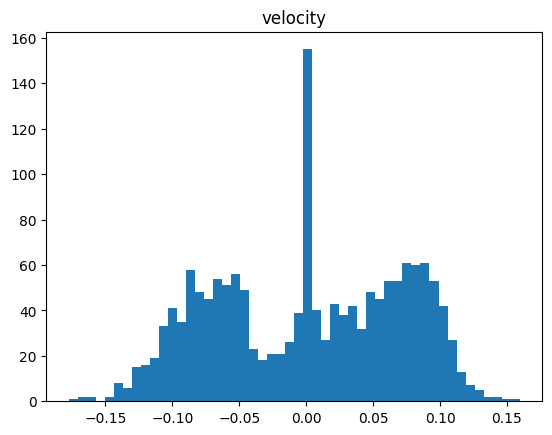

In [32]:
'''
load in data sampled at confocal fps
'''

json_dir = "/Users/friederikebuck/Desktop/MBL/project/data/Neuropal_no_heat/"
h5_dir ="/Users/friederikebuck/Desktop/MBL/project/data/processed_h5/"
dt, T, beh_data_confocal, _, _ = get_exp_features(exp_date, 
                                                            json_dir = json_dir, 
                                                            h5_dir = h5_dir)
behavior_features = get_behavior_features(beh_data_confocal)
beh_data_confocal.update(behavior_features)

behavior_classification_confocal = get_behavior_classification(beh_data_confocal, n_looping_pts_thres = 0.3, looping = is_looping_bin_img_confocal)
z_confocal = behavior_classification_confocal["is_fwd"]+ 2*behavior_classification_confocal["is_rev"]+ 4*behavior_classification_confocal["is_pause"]+3*behavior_classification_confocal["is_turn"]-1     
z_confocal = z_confocal.astype('int32')
z_nir = convert_confocal_to_nir(nir_to_confocal, z_confocal, indices_to_skip = set([])).astype('int32')
z_nir = z_nir.astype('int32')
z_nir[nir_to_confocal==0] = 4
beh = [
    "fwd", 
    "rev",
    "turn", 
    "pause", 
    "nan"
]
beh_strs = [beh[i] for i in z_nir]
beh_strs_confocal = [beh[i] for i in z_confocal]

velocity_nir =  convert_confocal_to_nir(nir_to_confocal, 
                                        beh_data_confocal["velocity"], 
                                        indices_to_skip = set([])).astype('int32')

fig, ax = plt.subplots()
ax.hist(beh_data_confocal["velocity"], bins = 50)
ax.set_title("velocity")


Text(0.5, 1.0, 'midline_lengths 0.02')

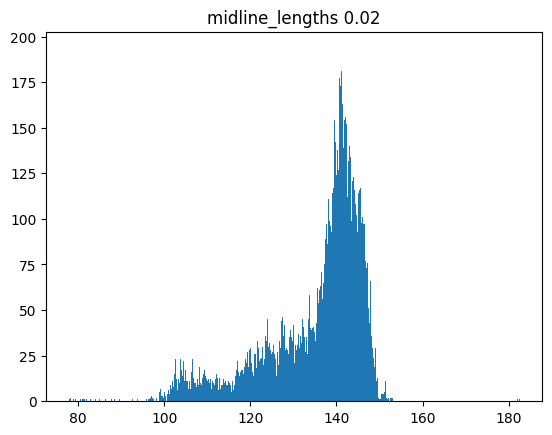

In [33]:


'''
from looking at mask imgs, it looks like midlines can be cut off; this is an issue for downstream analysis if different midlines are very different lengths...

I am assuming that the tail doesn't contribute much of the variance in behavior (an assumption that can be tested); thus one option is to only do analysis on 
the upper fraction of the midline. 

But, first, I have to get a good measure of midline length. I am fitting a spline and testing differnt ds's over which to integrate ....
based on the plots below, ds<0.05 seems fine 
'''

midlines = get_midlines_from_worm_tracer_csv(raw_nir_midlines_dir, is_midline_flipped = is_midline_flipped)
n_frames = midlines.shape[0]
frames = np.random.randint(0, n_frames, 9).tolist()
n_frames = len(frames)

ds = 0.02
fig, ax = plt.subplots()
midline_lengths, splines, indices  = compute_spline_lengths(midlines, ds=ds, smoothing = 0 )
ax.hist(midline_lengths, bins = 1000)
ax.set_title("midline_lengths " + str(ds))


In [35]:
# midline_save_dir = "/Users/friederikebuck/Desktop/MBL/project/figs/eigenworm_length_cuttoff_masked/"
'''
get eigenworms for different midline lengths 
'''


# midlines = get_midlines_from_worm_tracer_csv(raw_nir_midlines_dir, is_midline_flipped = is_midline_flipped)

ds = 0.02 
n_components = 8
num_resample_pts = 50


# for target_length in range(50,145, 10):
for target_length in range(50,160, 10):
    if np.argwhere(midline_lengths>target_length).flatten().shape[0]<10: 
        continue



    full_splines, to_keep, cropped_midlines,centroids,  midline_angles, mean_angles,  components, var_explained =  get_cropped_midlines_eigenworms_and_body_angles(
                                                        midlines, 
                                                        target_length, 
                                                        frames_to_mask,
                                                        ds = ds, 
                                                        n_components = n_components, 
                                                        num_resample_pts = num_resample_pts
                                                        )
    reconstructed_body_angles, reconstructed_midlines, contributions = get_contributions_and_reconstruct_body_angles(
                                                                    components, 
                                                                    midline_angles,
                                                                    mean_angles, 
                                                                    centroids, 
                                                                    target_length
                                                                    )
    print("target_length, ", target_length,"to_keep.shape", np.argwhere(to_keep).shape )

    '''
    get midlines cropped to target length specified 
    get eigenworms (PCAs of worm postures = body angles along spline) + from cropped midline 
    save pics of worms with overlain
        - spline fitted to midline
        - midlines cropped to target length specified  
        - reconstructed mdilen from eigenworm 
    
    '''
    n_frames = midlines.shape[0]
    frames = np.random.randint(0, n_frames, 9).tolist()

    print(target_length_fig_dir)

    for i, frame in enumerate(frames):
        fig, ax = plt.subplots()
        img = cv2.imread(os.path.join(mask_img_dir, str(frame+1).zfill(5)+".png"))
        ax.imshow(img)
        ax.set_title(str(target_length)+" "+str(frame))
        ax.scatter(*full_splines[frame].T, s = 4, label = "full spline" )
        ax.scatter(*cropped_midlines[frame].T, s = 10, alpha = 0.5, c = "violet", label = "cropped midline")
        ax.scatter(*reconstructed_midlines[frame].T, s = 4, alpha = 0.5, c = "violet", label = "reconstructed midline")
        ax.legend()
        fig.savefig(os.path.join(target_length_fig_dir, f"frame{frame}_len_thres{target_length}.jpeg"))
        

target_length,  50 to_keep.shape (18280, 1)


NameError: name 'target_length_fig_dir' is not defined